In [2]:
import PIL.Image
import numpy as np
from tkinter import *
import tkinter.filedialog
from os import  listdir, path
from time import time
from os import rename

# עיבוד התמונה

In [2]:
def processing(file_name):
    image=0
    image=np.asarray(PIL.Image.open(input_dir + file_name))
    h=len(image)
    w=len(image[1])
    if (len(image[0][0])==4):             #if the image is RGBA
        b=[]
        for l in range(h):
            a=[]
            for c in range(w):
                a.append(image[l,c][:3])
            b.append(a)
        image=b
    if (len(image[0][0])==3):
    # יוצר מטריצות נוחות לעיבוד
        trs=[]
        tgs=[]
        tbs=[]
        rs=[]
        gs=[]
        bs=[]
        for a in range(h):
            for b in range(w):
                trs.append(image[a][b][0])
                tgs.append(image[a][b][1])
                tbs.append(image[a][b][2])
        for a in range(0,int(len(trs)/w)):
            rs.append(trs[a*w:(a+1)*w])
            gs.append(tgs[a*w:(a+1)*w])
            bs.append(tbs[a*w:(a+1)*w])
        layers=np.array([rs,gs,bs])
        vector=np.array([trs,tgs,tbs])
    # יוצר היסטוגרמה בעבור כלל התמונה
        histo=[]
        groups=4
        no_zone=[]
        for a in range (0,3):
            histo=np.histogram(layers[a],bins=groups)
            maxi=np.max(histo[0])
            for b in range(0,groups):
                if (histo[0][b]==maxi):
                    no_zone.append(np.array([histo[1][b],histo[1][b+1]]))  
    # מוצא את השורות והטורים של הטבלה
        hor_ls=[]
        ver_ls=[]
        hor_ln=0
        ver_ln=0
        h=len(image)
        w=len(image[1])
        for a in range(0,3):    #עבור כל אחד מהצבעים
            l=0        #מתחיל עבור צבע מהשורה הראשונה את הבדיקה
            while (l<(h-2)):  #horizonal line detection
                while ((l in hor_ls)&(l<(h-2))):
                    l+=1
                c=0
                while (c<w):
                    if (len(hor_ls)==hor_ln):      #אם השורה הנוכחית לא התגלתה כבר בתור קו
                        if ((layers[a][l][c]<no_zone[a][0])|(layers[a][l][c]>no_zone[a][1])):
                            if (((layers[a][l][c]/255)**2>(layers[a][l+1][c]/255))|
                                ((layers[a][l][c]/255)<(layers[a][l+1][c]/255)**2)):#אם יש חשד שזה קו
                                T=c
                                pixels=[]
                                lng=0
                                while (T<w):
                                    pixels.append(layers[a][l][T])
                                    if ((np.mean((pixels-np.median(pixels))**2)>289)|
                                        (((layers[a][l][T]-np.median(pixels))**2)>5000)):   #אם זה לא קו
                                        break
                                    else:
                                        lng+=1    
                                    if ((lng>w/4)&((np.median(pixels)<no_zone[a][0])|
                                                   (np.median(pixels)>no_zone[a][1]))):   #horizonal line definition
                                        hor_ls.append(l)
                                        break
                                    T+=1   
                    else:
                        hor_ln+=1
                        break
                    c+=1
                l+=1
        for a in range(0,3):    #עבור כל אחד מהצבעים בחיפוש טורים
            c=0        #מתחיל עבור צבע מהשורה הראשונה את הבדיקה
            while (c<(w-2)):  #horizonal line detection
                while ((c in ver_ls)&(c<(w-2))):
                    c+=1
                l=0
                while (l<h):
                    if (len(ver_ls)==ver_ln):      #אם הטור הנוכחי לא התגלתה כבר בתור קו
                        if ((layers[a][l][c]<no_zone[a][0])|(layers[a][l][c]>no_zone[a][1])):
                            if (((layers[a][l][c]/255)**2>(layers[a][l][c+1]/255))|
                                ((layers[a][l][c]/255)<(layers[a][l][c+1]/255)**2)):#אם יש חשד שזה קו
                                s=l
                                pixels=[]
                                lng=0
                                while (s<h):
                                    pixels.append(layers[a][s][c])
                                    if ((np.mean((pixels-np.median(pixels))**2)>289)|
                                        (((layers[a][s][c]-np.median(pixels))**2)>5000)):   #אם זה לא קו
                                        break
                                    else:
                                        lng+=1    
                                    if ((lng>h/6)&((np.median(pixels)<no_zone[a][0])|
                                                   (np.median(pixels)>no_zone[a][1]))):   #horizonal line definition
                                        ver_ls.append(c)
                                        break
                                    s+=1   
                    else:
                        ver_ln+=1
                        break
                    l+=1
                c+=1
    # מסדר לפי גודל ומוחק כפילויות
        hor_ls=sorted(hor_ls)
        ver_ls=sorted(ver_ls)
        i=0
        while (i<(len(hor_ls)-2)):
            lng=0
            if (hor_ls[i+1]-hor_ls[i]==1):                    #אם מספרי השורות הם עוקבים   
                while (hor_ls[i+lng+1]-hor_ls[i+lng]==1):            #כל עוד מספרי השורות הם עוקבים
                    lng+=1
                    if (i+lng+2>len(hor_ls)):
                        break
                if (lng<(h/50)):                          #אם זה קו שמן
                    n=i
                    x=0
                    while (x<lng):       
                        if (n!=i+np.int(lng/2)+(lng%2)):    #אם זה לא אמצע הקו
                            hor_ls.remove(hor_ls[n])
                        else:
                            n+=1
                        x+=1
                else:                                       #אם זו שורה צבעונית עם צבע רקע
                    x=0
                    while (x<(lng-1)):
                        try:
                            hor_ls.remove(hor_ls[i+1])
                        except:
                            i+=1
                            pass
                        x+=1
            else:
                i+=1
        if (len(hor_ls)>1):
            if (hor_ls[-1]-hor_ls[-2]==1):
                hor_ls.remove(hor_ls[-2])
        i=0                                                #אותו דבר אבל על טורים
        while (i<(len(ver_ls)-2)):
            lng=0
            if (ver_ls[i+1]-ver_ls[i]==1):                    #אם מספרי הטורים הם עוקבים   
                while (ver_ls[i+lng+1]-ver_ls[i+lng]==1):            #כל עוד מספרי הטורים הם עוקבים
                    lng+=1
                    if (i+lng+2>len(ver_ls)):
                        break
                if (lng<(h/50)):                          #אם זה קו שמן
                    n=i
                    x=0
                    while (x<lng):       
                        if (n!=i+np.int(lng/2)+(lng%2)):    #אם זה לא אמצע הקו
                            ver_ls.remove(ver_ls[n])
                        else:
                            n+=1
                        x+=1
                else:                                       #אם זו שורה צבעונית עם צבע רקע
                    x=0
                    while (x<(lng-1)):
                        try:
                            hor_ls.remove(hor_ls[i+1])
                        except:
                            i+=1
                            pass
                        x+=1
            else:
                i+=1
        if (len(ver_ls)>1):
            if (ver_ls[-1]-ver_ls[-2]==1):
                ver_ls.remove(ver_ls[-2])
    # בודק אם הקו בצבע שונה מצבע תא הטבלה
        hor_box=[]
        for b in range(0,(len(hor_ls)-1)):             #בעבור כל שורה
            rbox=[]
            gbox=[]
            bbox=[]
            if (len(ver_ls)>1):
                for l in range(hor_ls[b],hor_ls[b+1]):   #בעבור כל שורות הפיקסלים שמרכיבות את השורה
                    for c in range(ver_ls[0],ver_ls[-1]):#בעבור כל הטורי הפיקסלים שמרכיבים את השורה
                        rbox.append(layers[0][l][c])
                        gbox.append(layers[1][l][c])
                        bbox.append(layers[2][l][c])
            hor_box.append(np.array([rbox,gbox,bbox]))
        hor_lines=[]
        for b in range(0,len(hor_ls)):             #בעבור כל שורה
            rl=[]
            gl=[]
            bl=[]
            if (len(ver_ls)>1):
                for c in range(ver_ls[0],ver_ls[-1]):#בעבור כל הטורי הפיקסלים שמרכיבים את השורה
                    rl.append(layers[0][hor_ls[b]][c])
                    gl.append(layers[1][hor_ls[b]][c])
                    bl.append(layers[2][hor_ls[b]][c])
            hor_lines.append(np.array([rl,gl,bl]))
        i=0
        hor_deltas=[]
        hor_lns_unis=[]
        while (i<len(hor_ls)):                   #בודק אם השורות דומות לרקע התאים
            if ((i!=0)&(i!=(len(hor_ls)-1))&(len(hor_ls)>1)):           #אם זו לא השורה הראשונה ולא השורה האחרונה תבדוק אם התא שלפני והתא שאחרי
                hor_deltas.append((np.median(hor_lines[i][0])-np.median(hor_box[i][0])/2-np.median(hor_box[i-1][0])/2)**2+
                                 (np.median(hor_lines[i][1])-np.median(hor_box[i][1])/2-np.median(hor_box[i-1][1])/2)**2+
                                 (np.median(hor_lines[i][2])-np.median(hor_box[i][2])/2-np.median(hor_box[i-1][2])/2)**2)
            elif (len(hor_ls)>1):
                if (i==0):              #אם זו השורה הראשונה
                    hor_deltas.append((np.median(hor_lines[i][0])-np.median(hor_box[i][0]))**2+
                                      (np.median(hor_lines[i][1])-np.median(hor_box[i][1]))**2+
                                      (np.median(hor_lines[i][2])-np.median(hor_box[i][2]))**2)
                else:                    #אם זו השורה האחרונה
                    hor_deltas.append((np.median(hor_lines[i][0])-np.median(hor_box[i-1][0]))**2+
                                      (np.median(hor_lines[i][1])-np.median(hor_box[i-1][1]))**2+
                                      (np.median(hor_lines[i][2])-np.median(hor_box[i-1][2]))**2)
            hor_lns_unis.append(np.median((np.median(hor_lines[i])-hor_lines)**2))                 #בודק את אחידות צבע הקוים
            i+=1
        hor_delta=np.median(hor_deltas)                #קלט ללמידת המכונה
        hor_lns_uni=np.median(hor_lns_unis)            #קלט ללמידת המכונה
        ver_box=[]
        ver_no_zone=[]
        for b in range(0,(len(ver_ls)-1)):             #בעבור כל טור
            rbox=[]
            gbox=[]
            bbox=[]
            if (len(hor_ls)>1):
                for c in range(ver_ls[b],ver_ls[b+1]):   #בעבור כל טורי הפיקסלים שמרכיבים את הטור
                    for l in range(hor_ls[0],hor_ls[-1]):#בעבור כל שורות הפיקסלים שמרכיבות את הטור
                        rbox.append(layers[0][l][c])
                        gbox.append(layers[1][l][c])
                        bbox.append(layers[2][l][c])
            ver_box.append(np.array([rbox,gbox,bbox]))
        ver_lines=[]
        for b in range(0,len(ver_ls)):             #בעבור כל טור
            rl=[]
            gl=[]
            bl=[]
            if (len(hor_ls)>1):
                for c in range(hor_ls[0],hor_ls[-1]):#בעבור כל שורות הפיקסלים שמרכיבות את הטור
                    rl.append(layers[0][c][ver_ls[b]])
                    gl.append(layers[1][c][ver_ls[b]])
                    bl.append(layers[2][c][ver_ls[b]])
            ver_lines.append(np.array([rl,gl,bl]))
        i=0
        ver_deltas=[]
        ver_lns_unis=[]
        while (i<len(ver_ls)):                       #בודק אם השורות דומות לרקע התאים
            if ((i!=0)&(i!=(len(ver_ls)-1))&(len(ver_ls)>1)):             #אם זו לא הטור הראשון ולא הטור האחרון תבדוק אם התא שמימין והתא שמשמאל
                ver_deltas.append((np.median(ver_lines[i][0])-np.median(ver_box[i][0])/2-np.median(ver_box[i-1][0])/2)**2+
                                  (np.median(ver_lines[i][1])-np.median(ver_box[i][1])/2-np.median(ver_box[i-1][1])/2)**2+
                                  (np.median(ver_lines[i][2])-np.median(ver_box[i][2])/2-np.median(ver_box[i-1][2])/2)**2)
            elif (len(ver_ls)>1):
                if (i==0):                  #אם זו הטור הראשון
                    ver_deltas.append((np.median(ver_lines[i][0])-np.median(ver_box[i][0]))**2+
                                      (np.median(ver_lines[i][1])-np.median(ver_box[i][1]))**2+
                                      (np.median(ver_lines[i][2])-np.median(ver_box[i][2]))**2)
                else:                     #אם זו הטור האחרון
                    ver_deltas.append((np.median(ver_lines[i][0])-np.median(ver_box[i-1][0]))**2+
                                     (np.median(ver_lines[i][1])-np.median(ver_box[i-1][1]))**2+
                                     (np.median(ver_lines[i][2])-np.median(ver_box[i-1][2]))**2)
            ver_lns_unis.append(np.median((np.median(ver_lines[i])-ver_lines)**2))                   #בודק את אחידות צבע הקוים
            i+=1    
        ver_delta=np.median(ver_deltas)                #קלט ללמידת המכונה
        ver_lns_uni=np.median(ver_lns_unis)            #קלט ללמידת המכונה
    # אחידות רוחב השורות והטורים
        uni_hor=[]
        for i in range (len(hor_ls)-1):
            uni_hor.append((hor_ls[i+1]-hor_ls[i])/h)
        uniform_hor=np.median((uni_hor-np.median(uni_hor))**2)                       #קלט ללמידת המכונה
        uni_ver=[]
        for i in range (len(ver_ls)-1):
            uni_ver.append((ver_ls[i+1]-ver_ls[i])/w)
        uniform_ver=np.median((uni_ver-np.median(uni_ver))**2)                       #קלט ללמידת המכונה
    # גודל הטבלה יחסית לגודל הדף (?) 
        if ((len(hor_ls)>0)&(len(ver_ls)>0)):
            h_covarage=(hor_ls[-1]-hor_ls[0])/h           #קלט ללמידת המכונה
            w_covarage=(ver_ls[-1]-ver_ls[0])/w           #קלט ללמידת המכונה
        else:
            h_covarage=0
            w_covarage=0
    # מכין מטריצה ללמידת מכונה
        if (file_name[:5]=="table"):
            polished_data.append(np.array([len(hor_ls),len(ver_ls),hor_delta,ver_delta,
                                           hor_lns_uni,ver_lns_uni,uniform_hor,uniform_ver,h_covarage,w_covarage,1]))
        else:
            polished_data.append(np.array([len(hor_ls),len(ver_ls),hor_delta,ver_delta,
                                           hor_lns_uni,ver_lns_uni,uniform_hor,uniform_ver,h_covarage,w_covarage,0]))
        np.save('polished_data', polished_data)                #למחוק בסוף
        return polished_data

# הרצת עיבוד התמונה עבור כל התמונות

In [3]:
input_dir="images/"
start=time()
polished_data=[]
for file_name in listdir(input_dir):                #מעבד כל תמונה בתקייה
    processing(file_name)
print (time()-start)

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


56060.79640364647


In [4]:
polished_data = np.load('polished_data.npy')
for i in range(len(polished_data)):                 #converts all the NaN to int
    for p in range(len(polished_data[0])):
        if (np.isnan(polished_data[i,p])):
            if (p==2|p==3):
                polished_data[i,p]=0
            else:
                polished_data[i,p]=65025
np.save('polished_data', polished_data)
len(polished_data[0])

11

# למידת המכונה

In [3]:
from sklearn import cross_validation
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import SigmoidLayer,SoftmaxLayer
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# בודק מה הגודל האידיאלי של שכבת הביניים

In [4]:
def sigmoid(x,deriv=False):           #יצירת פונקציית הסיגמואיד
    if (deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

(77, 1) (77, 1)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


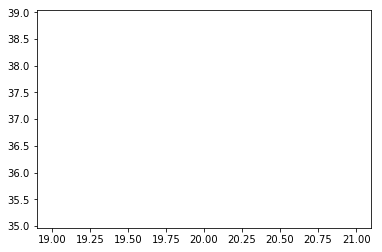

In [8]:
import matplotlib.pyplot as plt
counts=[]
mids=[]
polished_data = np.load('polished_data.npy')
np.random.shuffle(polished_data)   
x=polished_data[:,:10]
y=polished_data[:,10:11]
for midlle_layer in range (20,21):
    np.random.seed(1)
    syn0=2*np.random.random((len(x[0]),midlle_layer))-1
    syn1=2*np.random.random((midlle_layer,1))-1
    for i in range(1):
        l0=x
        l1=sigmoid(np.dot(l0,syn0))
        l2=sigmoid(np.dot(l1,syn1))
        l2_err=y-l2
        l2_delta=l2_err*sigmoid(l2,deriv=True)
        l1_err=l2_delta.dot(syn1.T)
        l1_delta=l1_err*sigmoid(l1,deriv=True)
        syn1+=l1.T.dot(l2_delta)
        syn0+=l0.T.dot(l1_delta)
    count=0
    for a in range(len(l2)):
        if (np.mean(l2[a])>0.5)&(y[a]==1):
            count+=1
        if (np.mean(l2[a])<0.5)&(y[a]==0):
            count+=1
        if (np.mean(l2[a])<0.5)&(y[a]==1):
            count-=1
    counts.append(count)
    mids.append(midlle_layer)
plt.plot(mids,counts)
plt.show()

# בדיקה של הרשת הטובה ביותר

In [17]:
polished_data = np.load('polished_data.npy')
midlle_layer=20
np.random.shuffle(polished_data)
x=polished_data[:,:10]
y=polished_data[:,10:11] 
best_err=1
np.random.seed(1)
syn0=2*np.random.random((len(x[0]),midlle_layer))-1
syn1=2*np.random.random((midlle_layer,1))-1
for i in range(10000):
    l0=x
    l1=sigmoid(np.dot(l0,syn0))
    l2=sigmoid(np.dot(l1,syn1))
    l2_err=y-l2
    l2_delta=l2_err*sigmoid(l2,deriv=True)
    l1_err=l2_delta.dot(syn1.T)
    l1_delta=l1_err*sigmoid(l1,deriv=True)
    syn1+=l1.T.dot(l2_delta)
    syn0+=l0.T.dot(l1_delta)
count=0
for a in range(len(l2)):
    if (np.mean(l2[a])>0.5)&(y[a]==1):
        count+=1
np.save("syn0",syn0)
np.save("syn1",syn1)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [8]:
polished_data=np.load('C:/Users/Gon/Documents/תיכנות/tab_ana/polished_data.npy')
x=polished_data[:,:10]
y=polished_data[:,10:11] 

In [11]:
np.shape(x)

(77, 10)